# Python: Panel Data Introduction

In this example, we replicate the results from the guide [Getting Started with the did Package](https://bcallaway11.github.io/did/articles/did-basics.html) of the [did-R-package](https://bcallaway11.github.io/did/index.html).

As the [did-R-package](https://bcallaway11.github.io/did/index.html) the implementation of [DoubleML](https://docs.doubleml.org/stable/index.html) is based on [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001).

The notebook requires the following packages:

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.data import DoubleMLPanelData
from doubleml.did import DoubleMLDIDMulti

## Data

The data we will use is simulated and part of the [CSDID-Python-Package](https://d2cml-ai.github.io/csdid/index.html).

A description of the data generating process can be found at the [CSDID-documentation](https://d2cml-ai.github.io/csdid/examples/csdid_basic.html#Examples-with-simulated-data).


In [2]:
dta = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/main/data/sim_data.csv")
dta.head()

,G,X,id,cluster,period,Y,treat
0,3,-0.876233,1,5,1,5.562556,1
1,3,-0.876233,1,5,2,4.349213,1
2,3,-0.876233,1,5,3,7.134037,1
3,3,-0.876233,1,5,4,6.243056,1
4,2,-0.873848,2,36,1,-3.659387,1


To work with the [DoubleML-package](https://docs.doubleml.org/stable/index.html), we initialize a ``DoubleMLPanelData`` object.

Therefore, we set the *never-treated* units in group column `G` to `np.inf` (we have to change the datatype to `float`).

In [3]:
# set dtype for G to float
dta["G"] = dta["G"].astype(float)
dta.loc[dta["G"] == 0, "G"] = np.inf
dta.head()

,G,X,id,cluster,period,Y,treat
0,3.0,-0.876233,1,5,1,5.562556,1
1,3.0,-0.876233,1,5,2,4.349213,1
2,3.0,-0.876233,1,5,3,7.134037,1
3,3.0,-0.876233,1,5,4,6.243056,1
4,2.0,-0.873848,2,36,1,-3.659387,1


Now, we can initialize the ``DoubleMLPanelData`` object, specifying

 - `y_col` : the outcome
 - `d_cols`: the group variable indicating the first treated period for each unit
 - `id_col`: the unique identification column for each unit
 - `t_col` : the time column
 - `x_cols`: the additional pre-treatment controls


In [4]:
dml_data = DoubleMLPanelData(
    data=dta,
    y_col="Y",
    d_cols="G",
    id_col="id",
    t_col="period",
    x_cols=["X"]
)
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['G']
Covariates: ['X']
Instrument variable(s): None
Time variable: period
Id variable: id
Static panel data: False
No. Unique Ids: 3979
No. Observations: 15916
------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15916 entries, 0 to 15915
Columns: 7 entries, G to treat
dtypes: float64(3), int64(4)
memory usage: 870.5 KB



## ATT Estimation

The [DoubleML-package](https://docs.doubleml.org/stable/index.html) implements estimation of group-time average treatment effect via the `DoubleMLDIDMulti` class (see [model documentation](https://docs.doubleml.org/stable/guide/models.html#difference-in-differences-models-did)).

The class basically behaves like other `DoubleML` classes and requires the specification of two learners (for more details on the regression elements, see [score documentation](https://docs.doubleml.org/stable/guide/scores.html#difference-in-differences-models)). The model will be estimated using the `fit()` method.

In [5]:
dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LinearRegression(),
    ml_m=LogisticRegression(),
    control_group="never_treated",
)

dml_obj.fit()
print(dml_obj)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['G']
Covariates: ['X']
Instrument variable(s): None
Time variable: period
Id variable: id
Static panel data: False
No. Unique Ids: 3979
No. Observations: 15916
------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.42570604 1.41125384 1.39737576 1.42693957 1.40431614 1.42095285
  1.42479372 1.40662505 1.42336668]]
Learner ml_g1 RMSE: [[1.40253799 1.43745417 1.39593591 1.41758451 1.425797   1.38359612
  1.45614116 1.41703303 1.4133427 ]]
Classification:
Learner ml_m Log Loss: [[0.69134011 0.69130619 0.69147426 0.67930238 0.67920539 0.67921201
  0.66211466 0.66

The summary displays estimates of the $ATT(g,t_\text{eval})$ effects for different combinations of $(g,t_\text{eval})$ via $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$, where
 - $\mathrm{g}$ specifies the group
 - $t_\text{pre}$ specifies the corresponding pre-treatment period
 - $t_\text{eval}$ specifies the evaluation period

This corresponds to the estimates given in `att_gt` function in the [did-R-package](https://bcallaway11.github.io/did/index.html), where the standard choice is $t_\text{pre} = \min(\mathrm{g}, t_\text{eval}) - 1$ (without anticipation).

Remark that this includes pre-tests effects if $\mathrm{g} > t_{eval}$, e.g. $ATT(4,2)$.

As usual for the DoubleML-package, you can obtain joint confidence intervals via bootstrap.

In [6]:
level = 0.95

ci = dml_obj.confint(level=level)
dml_obj.bootstrap(n_rep_boot=5000)
ci_joint = dml_obj.confint(level=level, joint=True)
ci_joint

,2.5 %,97.5 %
"ATT(2.0,1,2)",0.752228,1.097864
"ATT(2.0,1,3)",1.815471,2.164331
"ATT(2.0,1,4)",2.781145,3.122008
"ATT(3.0,1,2)",-0.220149,0.135309
"ATT(3.0,2,3)",0.931148,1.284369
"ATT(3.0,2,4)",1.881102,2.234111
"ATT(4.0,1,2)",-0.183282,0.185583
"ATT(4.0,2,3)",-0.120076,0.238124
"ATT(4.0,3,4)",0.770529,1.134039


A visualization of the effects can be obtained via the `plot_effects()` method.

Remark that the plot used joint confidence intervals per default. 

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


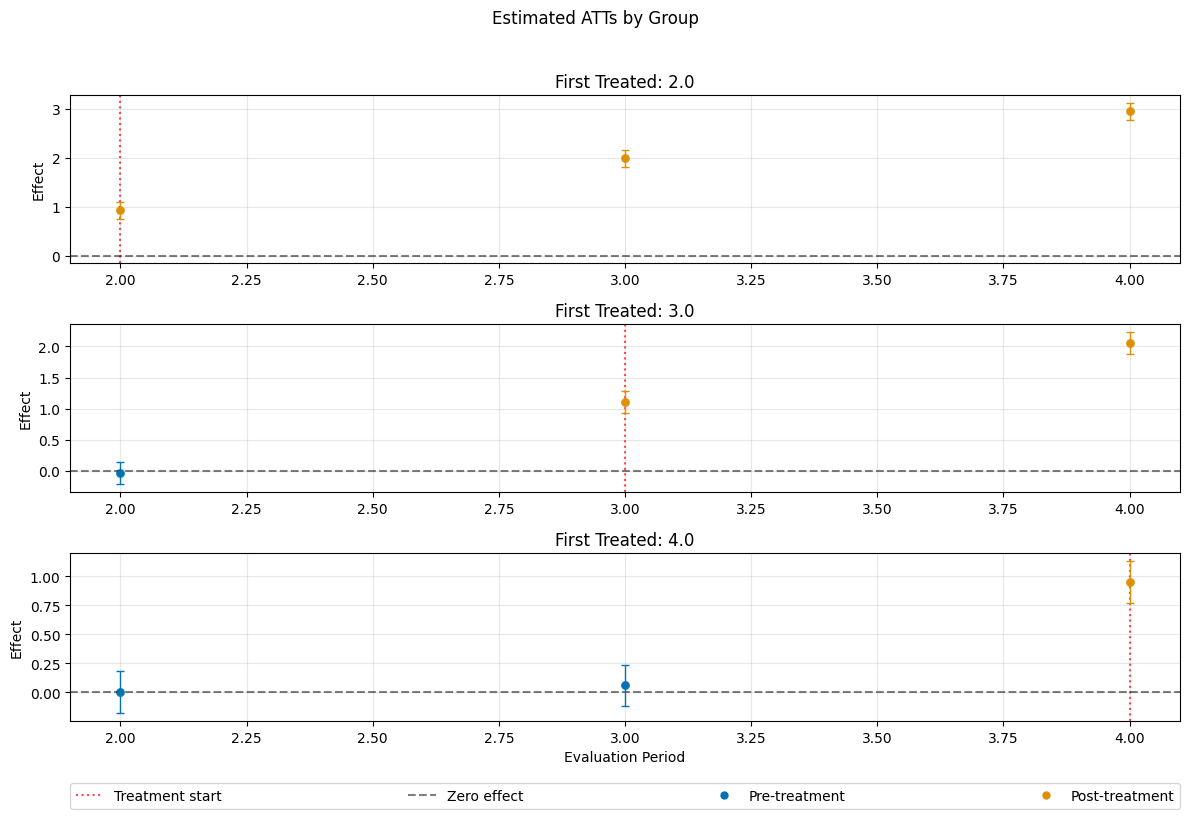

In [7]:
fig, ax = dml_obj.plot_effects()

## Effect Aggregation

As the [did-R-package](https://bcallaway11.github.io/did/index.html), the $ATT$'s can be aggregated to summarize multiple effects.
For details on different aggregations and details on their interpretations see [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001).

The aggregations are implemented via the `aggregate()` method.

### Group Aggregation

To obtain group-specific effects it is possible to aggregate several $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$ values based on the group $\mathrm{g}$ by setting the `aggregation="group"` argument.

================== DoubleMLDIDAggregation Object ==================
 Group Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.488075 0.034276 43.414605    0.0 1.420896 1.555255
------------------ Aggregated Effects         ------------------
         coef   std err          t  P>|t|     2.5 %    97.5 %
2.0  1.955508  0.052228  37.441477    0.0  1.853142  2.057874
3.0  1.582683  0.056293  28.114920    0.0  1.472350  1.693016
4.0  0.952284  0.067396  14.129613    0.0  0.820189  1.084378
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:368: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


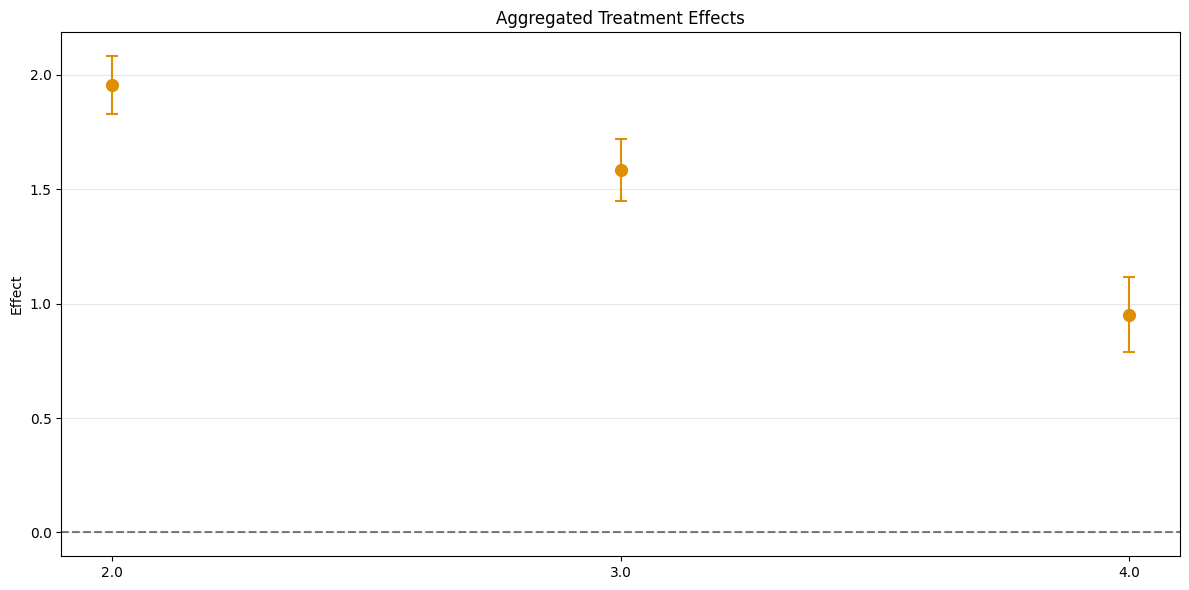

In [8]:
aggregated = dml_obj.aggregate(aggregation="group")
print(aggregated)
_ = aggregated.plot_effects()

The output is a `DoubleMLDIDAggregation` object which includes an overall aggregation summary based on group size.

### Time Aggregation

This aggregates $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$, based on $t_\text{eval}$, but weighted with respect to group size. Corresponds to *Calendar Time Effects* from the [did-R-package](https://bcallaway11.github.io/did/index.html).

For calendar time effects set `aggregation="time"`.

================== DoubleMLDIDAggregation Object ==================
 Time Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.481981 0.035131 42.184033    0.0 1.413125 1.550837
------------------ Aggregated Effects         ------------------
       coef   std err          t  P>|t|     2.5 %    97.5 %
2  0.925046  0.064082  14.435289    0.0  0.799447  1.050645
3  1.550183  0.051418  30.148767    0.0  1.449406  1.650960
4  1.970714  0.046649  42.245549    0.0  1.879284  2.062144
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:368: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


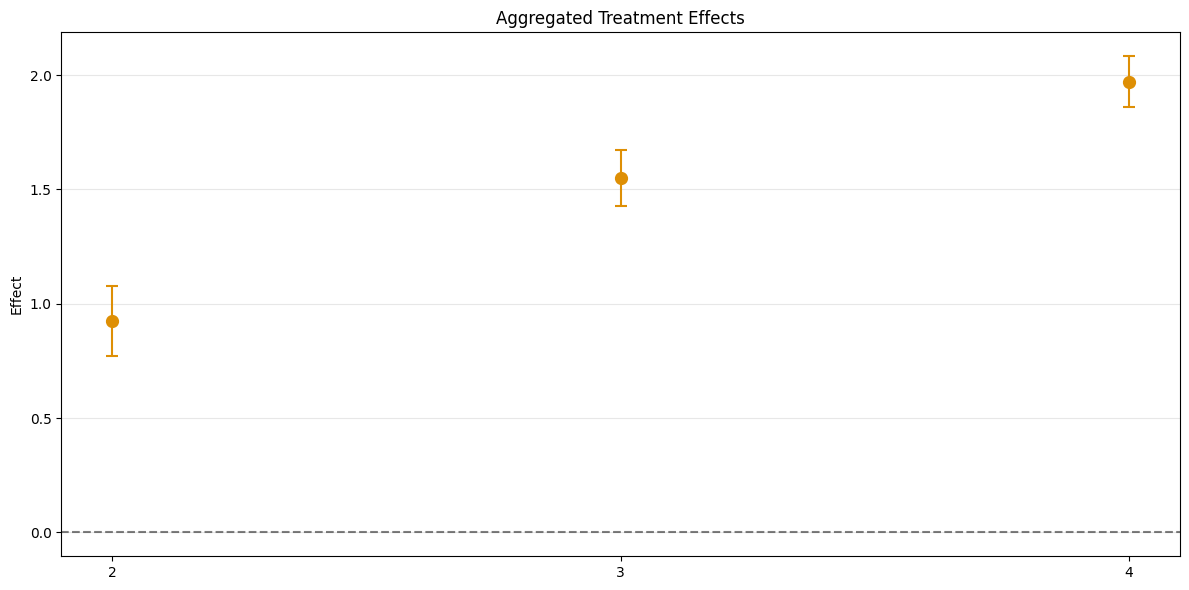

In [9]:
aggregated_time = dml_obj.aggregate("time")
print(aggregated_time)
fig, ax = aggregated_time.plot_effects()

### Event Study Aggregation

Finally, `aggregation="eventstudy"` aggregates $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$ based on exposure time $e = t_\text{eval} - \mathrm{g}$ (respecting group size).

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.989785 0.038764 51.330523    0.0 1.913809 2.065762
------------------ Aggregated Effects         ------------------
          coef   std err          t     P>|t|     2.5 %    97.5 %
-2.0  0.001150  0.068389   0.016821  0.986580 -0.132890  0.135190
-1.0  0.009644  0.040465   0.238332  0.811624 -0.069665  0.088953
0.0   0.994130  0.030770  32.308489  0.000000  0.933822  1.054437
1.0   2.023650  0.045726  44.256098  0.000000  1.934029  2.113271
2.0   2.951577  0.063197  46.704042  0.000000  2.827712  3.075441
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:368: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


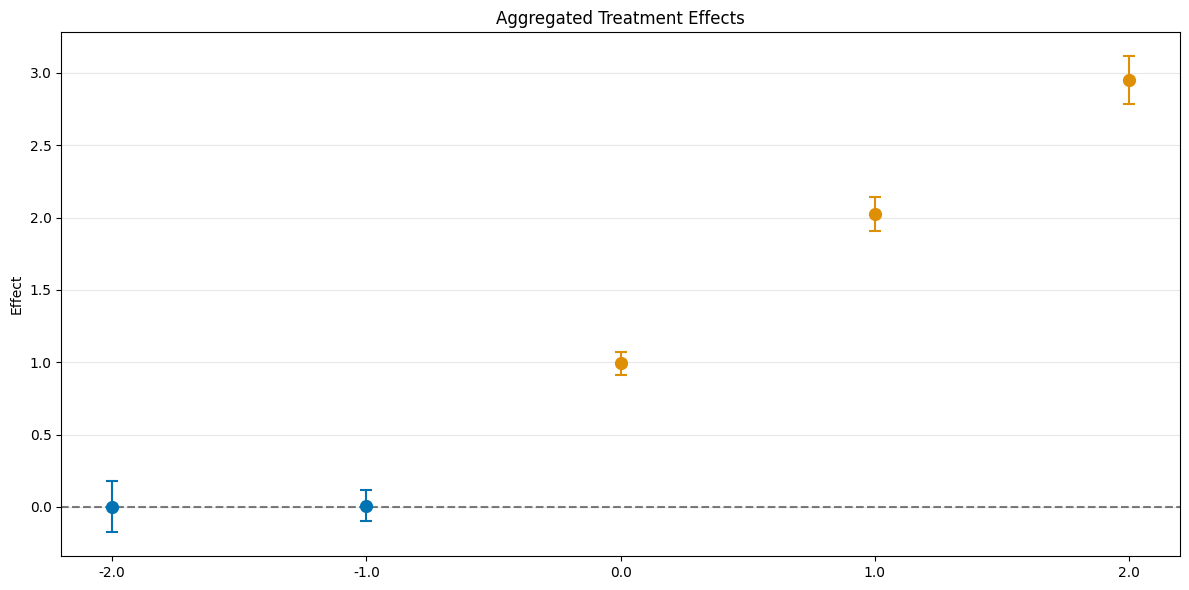

In [10]:
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
print(aggregated_eventstudy)
fig, ax = aggregated_eventstudy.plot_effects()

### Aggregation Details

The `DoubleMLDIDAggregation` objects include several `DoubleMLFrameworks` which support methods like `bootstrap()` or `confint()`.
Further, the weights can be accessed via the properties

 - ``overall_aggregation_weights``: weights for the overall aggregation
 - ``aggregation_weights``: weights for the aggregation

To clarify, e.g. for the eventstudy aggregation

In [11]:
print(aggregated_eventstudy)

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.989785 0.038764 51.330523    0.0 1.913809 2.065762
------------------ Aggregated Effects         ------------------
          coef   std err          t     P>|t|     2.5 %    97.5 %
-2.0  0.001150  0.068389   0.016821  0.986580 -0.132890  0.135190
-1.0  0.009644  0.040465   0.238332  0.811624 -0.069665  0.088953
0.0   0.994130  0.030770  32.308489  0.000000  0.933822  1.054437
1.0   2.023650  0.045726  44.256098  0.000000  1.934029  2.113271
2.0   2.951577  0.063197  46.704042  0.000000  2.827712  3.075441
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



Here, the overall effect aggregation aggregates each effect with positive exposure

In [12]:
print(aggregated_eventstudy.overall_aggregation_weights)

[0.         0.         0.33333333 0.33333333 0.33333333]


If one would like to consider how the aggregated effect with $e=0$ is computed, one would have to look at the third set of weights within the ``aggregation_weights`` property

In [13]:
aggregated_eventstudy.aggregation_weights[2]

array([0.32875335, 0.        , 0.        , 0.        , 0.32674263,
       0.        , 0.        , 0.        , 0.34450402])

Taking a look at the original `dml_obj`, one can see that this combines the following estimates:

 - $\widehat{ATT}(2,1,2)$
 - $\widehat{ATT}(3,2,3)$
 - $\widehat{ATT}(4,3,4)$

In [14]:
print(dml_obj.summary)

                  coef   std err          t     P>|t|     2.5 %    97.5 %
ATT(2.0,1,2)  0.925046  0.064082  14.435289  0.000000  0.799447  1.050645
ATT(2.0,1,3)  1.989901  0.064680  30.765315  0.000000  1.863130  2.116671
ATT(2.0,1,4)  2.951577  0.063197  46.704042  0.000000  2.827712  3.075441
ATT(3.0,1,2) -0.042420  0.065903  -0.643667  0.519791 -0.171588  0.086748
ATT(3.0,2,3)  1.107759  0.065489  16.915284  0.000000  0.979403  1.236114
ATT(3.0,2,4)  2.057607  0.065449  31.438197  0.000000  1.929328  2.185885
ATT(4.0,1,2)  0.001150  0.068389   0.016821  0.986580 -0.132890  0.135190
ATT(4.0,2,3)  0.059024  0.066412   0.888755  0.374135 -0.071141  0.189188
ATT(4.0,3,4)  0.952284  0.067396  14.129613  0.000000  0.820189  1.084378
